In [1]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from Graph import *
from math import sqrt

import seaborn as sns
import numpy as np



## Test the Graph class

In [ ]:
vertex1 = Vertex(60, 2, 0)
vertex2 = Vertex(61, 3, 0)

edge = Edge([vertex1, vertex2])

print(edge.angle, edge.length, edge.intermediate_point())

In [ ]:
graph = Graph(warnings = True)

last_vertex = Vertex(-1, -1, 0, warnings = True)
graph.add_vertices(last_vertex)

for i in range(0,10):
    new_vertex = Vertex(i, i, 0, warnings = True)
    edge = Edge(vertices = [last_vertex, new_vertex], warnings = True)
    graph.add_vertices(new_vertex)
    last_vertex = new_vertex

In [ ]:
pp.pprint(graph.vertices)
pp.pprint(graph.edges)
    
for i in range(5):
    cur_vertex = next(iter(graph.vertices))
    cur_vertex.set_graph(None)

    pp.pprint(graph.vertices)
    pp.pprint(graph.edges)
    pp.pprint("")

In [ ]:
print(calculate_angle(60, 61, 2, 3))
print(calculate_angle(60, 61, 3, 2))

## Angle graphifying

In [2]:
df = pd.read_csv("presets/0.csv")

In [3]:
tra = df["trajectory"].unique()[0]
dft = df[df["trajectory"] == tra]

In [ ]:
# Additional idea: combine edges with similar angles
# For report we attempt to model the topology of a city (vertices, edges and planes) of a city from geographical data

### Testing division

In [ ]:
# divide latitude by 69 and longitude by 52

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


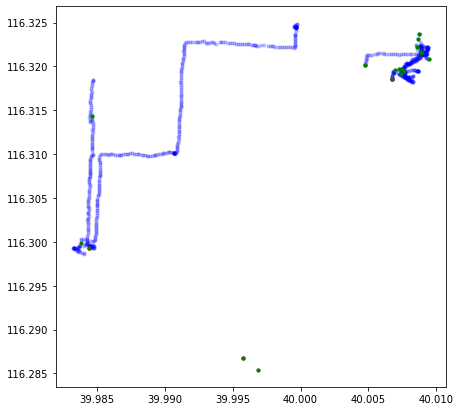

In [4]:

dft.loc[:, "latitude_change"] = dft.loc[:,"latitude"] - dft.loc[:,"latitude"].shift(1)
dft.loc[:, "longitude_change"] = dft.loc[:,"longitude"] - dft.loc[:,"longitude"].shift(1)

def pythago(lat, long):
    return sqrt(lat*lat + long*long)

dft.loc[:,["change"]] = dft.apply(lambda x: pythago(x.latitude_change, x.longitude_change), axis=1)

maximum = dft.loc[:,"change"].mean()*10
fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(dft.latitude, dft.longitude, zorder=1, alpha= 0.2, c='b', s=10)

df1 = dft[dft["change"] > dft["change"].mean()*10]
ax.scatter(df1.latitude, df1.longitude, zorder=1, alpha=1, c='r', s=10)

q25 = dft["change"].quantile(0.25)
q75 = dft["change"].quantile(0.75)
df2 = dft[dft["change"] > (q75 + 1.5*(q75 + q25))]
ax.scatter(df2.latitude, df2.longitude, zorder=1, alpha=1, c='g', s=10)

### The actual graph

In [13]:
# Method 1: check if the angle between current and previous vertex is too different from first angle in sequence
# Method 2: check if the angle between current and first vertex in the sequence is too different from first angle in sequence
# Method 3: method 2, but the max angle is affected by the distance from the first vertex in the sequence

def create_graph(df, max_angle_change = 45, method = 3, 
                 max_angle_change_min = 5, distance_multiplier = None, splitting_method = 2):
    
    mean_distance = df["change"].mean()
    skip_next = False
    
    # Splitting distance is defined by a multiple of the mean
    if splitting_method == 1:
        if distance_multiplier == None: distance_multiplier = 5
        max_distance = mean_distance*distance_multiplier
    
    # Splitting distance is difined by the quantiles
    elif splitting_method == 2:
        if distance_multiplier == None: distance_multiplier = 1.5
        q25 = df["change"].quantile(0.25)
        q75 = df["change"].quantile(0.75)
        max_distance = (q75 + distance_multiplier*(q75 +-q25))
        
    graph = Graph()
    
    # The start of the current sequence
    start_latitude = df.iloc[0, 0]
    start_longitude = df.iloc[0, 1]
    altitude = df.iloc[0, 2]
    
    # The last point
    start_vertex = Vertex(start_latitude, start_longitude, altitude, graph)
    last_latitude = df.iloc[1, 0]
    last_longitude = df.iloc[1, 1]
    last_altitude = df.iloc[1, 2]
    
    # The last angle to the vertex befor it
    compare_last_angle = start_vertex.angle_to_point(last_latitude, last_longitude)
    
    # The last angle to the start vertex in the current_sequence
    compare_start_angle = start_vertex.angle_to_point(last_latitude, last_longitude)
    
    # For every point in the dataframe (in order)
    for i in range(2,len(df)):
        cur_latitude = df.iloc[i, 0]
        cur_longitude = df.iloc[i, 1]   
        cur_altitude = df.iloc[i, 2]
        
        last_distance = sqrt(pow(last_latitude-cur_latitude, 2) + pow(last_longitude-cur_longitude,2))
        
        # If the last iteration noticed a skip, create a new start
        if skip_next == True:
            new_vertex = Vertex(last_latitude, last_longitude, last_altitude, graph)
            
            compare_angle = calculate_angle(last_latitude, cur_latitude, last_longitude, cur_longitude)
            start_vertex = new_vertex

            start_altitude = last_altitude
            start_longitude = last_longitude
            
            skip_next = False            
        
        # If the distance is to large do not connect
        elif last_distance > max_distance:
            new_vertex = Vertex(last_latitude, last_longitude, last_altitude, graph)
            Edge([start_vertex, new_vertex])
            
            skip_next = True
        
        # Normal case of connecting
        else:
            if method == 1:
                last_angle = calculate_angle(last_latitude, cur_latitude, last_longitude, cur_longitude)

                condition = ((abs(compare_last_angle-last_angle) + 180) % 360 - 180) > max_angle_change

            elif method == 2:
                start_angle = calculate_angle(start_latitude, cur_latitude, start_longitude, cur_longitude)
                
                condition = ((abs(compare_start_angle-start_angle) + 180) % 360 - 180) > max_angle_change

            elif method == 3:
                start_angle = calculate_angle(start_latitude, cur_latitude, start_longitude, cur_longitude)
                
                start_distance = sqrt(pow(start_latitude-cur_latitude, 2) + pow(start_longitude-cur_longitude,2))
                max_angle = max(max_angle_change*mean_distance/start_distance, max_angle_change_min)
                
                condition = ((abs(compare_start_angle-start_angle) + 180) % 360 - 180) > max_angle
            
            elif method == 4:
                last_angle = calculate_angle(last_latitude, cur_latitude, last_longitude, cur_longitude)
                start_angle = calculate_angle(start_latitude, cur_latitude, start_longitude, cur_longitude)
                
                condition = (((abs(compare_last_angle-last_angle) + 180) % 360 - 180) > max_angle_change)\
                and (((abs(compare_start_angle-start_angle) + 180) % 360 - 180) > max_angle_change)
            
            # Create new vertex if the angle is too different
            if condition:
                new_vertex = Vertex(last_latitude, last_longitude, last_altitude, graph)
                Edge([start_vertex, new_vertex])
                
                try: compare_last_angle = last_angle
                except:continue
                    
                try:compare_start_angle = start_angle
                except: continue

                start_vertex = new_vertex

                start_altitude = last_altitude
                start_longitude = last_longitude

        last_latitude = cur_latitude
        last_longitude = cur_longitude
        last_altitude = cur_altitude

    new_vertex = Vertex(last_latitude, last_longitude, last_altitude, graph)
    Edge([start_vertex, new_vertex])
    
    return graph

reduced from 907 to 38 points


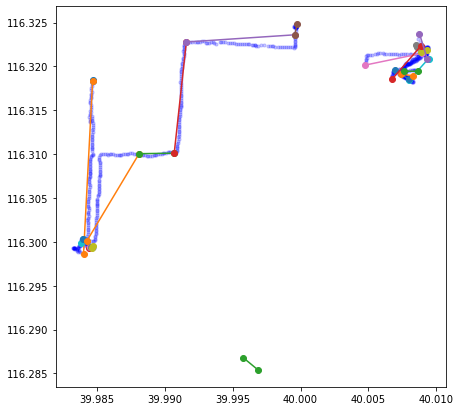

In [14]:
graph = create_graph(dft, method = 4, splitting_method = 2, distance_multiplier = 5, max_angle_change = 15)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(dft.latitude, dft.longitude, zorder=1, alpha= 0.2, c='b', s=10)

for edge in graph.edges:
    lat1 = min(edge.vertices).latitude
    long1 = min(edge.vertices).longitude
    
    lat2 = max(edge.vertices).latitude
    long2 = max(edge.vertices).longitude
    
    plt.plot([lat1, lat2], [long1, long2], marker = 'o')

star_vertices = [vertex for vertex in graph.vertices if len(vertex.edges) == 1]
for vertex in star_vertices:
    ax.plot(vertex.latitude, vertex.longitude, markersize=50)
    
ax = plt.gca()
#ax.set_xlim([40.0035, 40.0115])
#ax.set_ylim([116.3175, 116.3245])
print(f"reduced from {len(dft)} to {len(graph.vertices)} points")

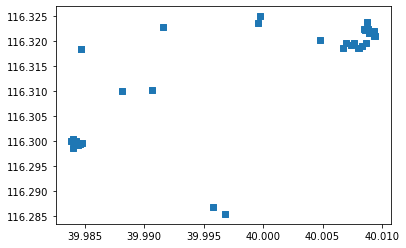

In [16]:
plot_edges(graph.vertices)

In [ ]:
# change gaps into different trajectory
# add distance to angle calculation